# Hidden Markov Models

For users already familiar with the interface, the [API docs](../api/index_markov_hmm.rst).

Hidden Markov models (HMM) are a type of Markov model where the underlying Markov process $X_t$ is _hidden_ and there is an _observable_ process $Y_t$ which depends on $X_t$. A nice introduction into HMM theory and related algorithms can be found in <cite data-cite="nbhmm-rabiner1989tutorial">(Rabiner, 1989)</cite>. When fitting such a model, the goal is to parameterize a Markov model over $X_t$ by observing $Y_t$. Here the dependency of $Y_t$ on $X_t$ must only depend on the current time step, i.e.,

$$ \mathbb{P}(Y_t \in A \mid X_1 = x_1, \ldots, X_n = x_n) = \mathbb{P}(Y_t \in A \mid X_n = x_n), $$

where $A$ is some measurable set in observation space.

The states of process $X_i$ are often called "hidden states" or "macro states", whereas $\mathbb{P}(Y_t\in A \mid X_n = x_n)$ is referred to as output probability or emission probability. If the emission probability is a discrete probability distribution, the corresponding states are often called "observable" or "micro" states.

In particular, this means that here - as opposed to in ordinary [Markov state models](mlmsm.ipynb) - one hidden state maps to a probability distribution over the observable space in which $Y_t$ takes its values.

HMMs are generally more expressive as MSMs, as each MSM can be written in terms of an HMM with discrete output probabilities: The transition matrix can be used as hidden transition matrix and the emission probabilities reduce to the identity, i.e., there are as many hidden states as there are observable states and each hidden state maps to a delta distribution. HMMs relax this by allowing for other distributions too.

Due to their more general nature, HMMs can recover from situations and produce good results when MSMs would not, for example in some cases of bad state space discretization. However, HMMs are harder to fit, computationally more expensive, and the estimation likes to get stuck in local optima.

In deeptime, a hidden Markov model is determined by

- a hidden transition model $P\in\mathbb{R}^{n\times n}$ (of type [MarkovStateModel](../api/generated/deeptime.markov.msm.MarkovStateModel.rst#deeptime.markov.msm.MarkovStateModel)) describing the hidden process,
- an [output model](../api/generated/deeptime.markov.hmm.OutputModel.rst#deeptime.markov.hmm.OutputModel), which holds information on the emission probabilities,
- and an initial distribution $\pi\in\mathbb{R}^n$ over the hidden states, which expresses a prior belief over the average most likely distribution of hidden states.

Creating an [HMM](../api/generated/deeptime.markov.hmm.HiddenMarkovModel.rst#deeptime.markov.hmm.HiddenMarkovModel) is as simple as importing deeptime and fixing at least the transition model and the output model.

Here $P\in\mathbb{R}^{2\times 2}$ is the hidden transition matrix and $E\in\mathbb{R}^{2\times 3}$ are the emission probabilities mapping from two hidden states to two three-state output probability distributions:

In [1]:
import numpy as np
import deeptime
import deeptime.markov.hmm as hmm

P = np.array([[0.95, 0.05], [0.3, 0.7]])
E = np.array([
    [0.1, 0.1, 0.8], [0.5, 0.5, 0.]
])

ground_truth = hmm.HiddenMarkovModel(P, E)

This hidden Markov model has two hidden (macro) states and three output (micro) states. The initial distribution defaults to a uniform distribution, which prefers no hidden state over the other.

In [2]:
print("# hidden states:", ground_truth.n_hidden_states)
print("# observation states:", ground_truth.n_observation_states)

# hidden states: 2
# observation states: 3


We can now generate an hidden and corresponding observation sequence from the hmm:

In [3]:
(hidden_trajectory, observation_trajectory) = ground_truth.simulate(2000)

Visualizing the hidden trajectory, one can observe that state 0 is preferred. The observation trajectory jumps between three states. If the hidden state is $0$, the observation trajectory is most of the time in micro state $2$, otherwise it is in state $0$ or $1$:

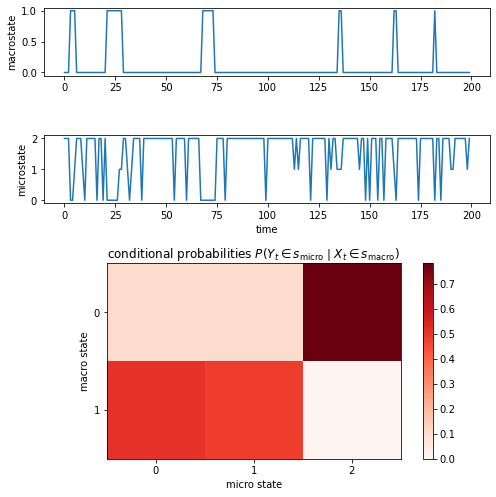

In [4]:
import matplotlib.pyplot as plt

f = plt.figure(constrained_layout=False, figsize=(7, 7))
gs = f.add_gridspec(nrows=4, ncols=1)
ax1 = f.add_subplot(gs[0, 0])
ax2 = f.add_subplot(gs[1, 0])
ax3 = f.add_subplot(gs[2:, 0])

ax1.plot(hidden_trajectory[:200])
ax1.set_ylabel("macrostate")
ax2.plot(observation_trajectory[:200])
ax2.set_xlabel("time")
ax2.set_ylabel("microstate")

probabilities = np.zeros((2, 3))
for i_hidden in range(2):
    for i_obs in range(3):
        # indices where macro state is i_hidden
        hidden_ix = np.argwhere(hidden_trajectory == i_hidden).flatten()
        subselected_obs = observation_trajectory[hidden_ix]
        # indices where micro state is i_obs given i_hidden
        obs_ix = np.argwhere(subselected_obs == i_obs).flatten()
        probabilities[i_hidden, i_obs] = len(obs_ix) / len(hidden_ix)

cb = ax3.matshow(probabilities, cmap="Reds")
ax3.xaxis.set_ticks_position('bottom')
ax3.set_xlabel("micro state")
ax3.set_ylabel("macro state")
ax3.set_title(r"conditional probabilities $P(Y_t\in s_\mathrm{micro}\mid X_t\in s_\mathrm{macro})$")
f.colorbar(cb, ax=ax3)
plt.tight_layout();

While the output probabilities in this case map to discrete values, this is not the only option. We implement

- the [discrete output model](../api/generated/deeptime.markov.hmm.DiscreteOutputModel.rst#deeptime.markov.hmm.DiscreteOutputModel), which maps to a discrete observable space and is parameterized by a row-stochastic output probability matrix $E\in\mathbb{R}^{n\times m}$, where $n$ is the number hidden and $m$ the number of observable states,
- and the [Gaussian output model](../api/generated/deeptime.markov.hmm.GaussianOutputModel.rst#deeptime.markov.hmm.GaussianOutputModel), which maps to a one-dimensional output space with $m$ Gaussians, each parameterized by mean and standard deviation.

## Estimation

The estimation of an HMM given sequences of observations can be performed using the Baum-Welch algorithm <cite data-cite="nbhmm-baum1967inequality">(Baum, 1967)</cite>, which belongs to the family of expectation-maximization algorithms.

It crucially requires an initial guess for emission probabilities and hidden state transition matrix, as the optimization is prone to getting stuck in local optima. After optimization, the likelihood for a trained model is available and can be compared to models with different initial guesses.

Going back to above example, we can try to fit an HMM based on the observation trajectory for different initial guesses:

In [5]:
hmm_est_real = hmm.MaximumLikelihoodHMM(
    initial_model=ground_truth
).fit(observation_trajectory).fetch_model()

In [6]:
print("Maximum absolute deviation: {:.3f}".format(
    np.max(np.abs(hmm_est_real.transition_model.transition_matrix - P))
))

Maximum absolute deviation: 0.022


When initialized with the ground truth, the deviation is not large from the initial model. Deeptime furthermore offers some initialization heuristics should the ground truth be unknown.

For discrete output models:

1. [init.discrete.metastable_from_data](../api/generated/deeptime.markov.hmm.init.discrete.metastable_from_data.rst#deeptime.markov.hmm.init.discrete.metastable_from_data) or [init.discrete.metastable_from_msm](../api/generated/deeptime.markov.hmm.init.discrete.metastable_from_msm.rst#deeptime.markov.hmm.init.discrete.metastable_from_msm): A reversible [MSM](mlmsm.ipynb) is estimated from given discrete trajectories. This is optional in case the MSM is already available. Then, the estimated transition matrix $P\in\mathbb{R}^{n\times n}$ is coarse-grained with PCCA+ <cite data-cite="nbhmm-roblitz2013fuzzy">(Röblitz, 2013)</cite>, yielding $m$ metastable/macro states and a membership matrix $M\in\mathbb{R}^{n\times m}$. The transition matrix is projected into hidden space via
    $$ P_\mathrm{coarse} = (M^\top M)^{-1}M^\top PM. $$
    This procedure is described in greater detail in <cite data-cite="nbhmm-noe2013projected">(Noé, 2013)</cite>.
2. [init.discrete.random_guess](../api/generated/deeptime.markov.hmm.init.discrete.random_guess.rst#deeptime.markov.hmm.init.discrete.random_guess): Initializes hidden transition matrix and initial distribution uniformly, the emission probabilities are drawn from the uniform distribution $\mathcal{U}(0, 1)$ and normalized to form a row-stochastic matrix.

Let's create a random initial model and use it as starting point for the maximum-likelihood estimation.

In [7]:
init_hmm_random = hmm.init.discrete.random_guess(n_observation_states=3, n_hidden_states=2)
hmm_est_random = hmm.MaximumLikelihoodHMM(
    initial_model=init_hmm_random
).fit(observation_trajectory).fetch_model()

Also here, we can compute the maximum deviation from ground truth hidden transition matrix:

In [8]:
print("Maximum absolute deviation: {:.3f}".format(
    np.max(np.abs(hmm_est_random.transition_model.transition_matrix - P))
))

Maximum absolute deviation: 0.268


And evaluate the likelihood of the model

In [9]:
hmm_est_random.likelihood

-1591.3912095865114

As well as compute the likelihood of the generated data given our original model.

In [10]:
ground_truth.compute_observation_likelihood(observation_trajectory)

-1594.2261122785756

## Bayesian sampling

Bayesian sampling of HMMs can be used to obtain confidences. In particular, Gibbs sampling can be performed around a reference HMM, as introduced in <cite data-cite="nbhmm-chodera2011bayesian">(Chodera, 2011)</cite>. In deeptime, a [BayesianHMM](../api/generated/deeptime.markov.hmm.BayesianHMM.rst#deeptime.markov.hmm.BayesianHMM) estimator is provided.

The easiest method to obtain a BayesianHMM estimator from data is the [default()](../api/generated/deeptime.markov.hmm.BayesianHMM.rst#deeptime.markov.hmm.BayesianHMM.default) static method. It estimates an ML-MSM on data, coarse-grains it to the requested number of hidden states and uses it as starting point for an ML-HMM estimation. The resulting model is used as start sample for the BayesianHMM estimator.

In [11]:
estimator = hmm.BayesianHMM.default(observation_trajectory, n_hidden_states=2, lagtime=1)

The maximum-likelihood estimation is done for fewer iterations and with less precision than the default settings, as a rough estimate suffices to start sampling.

In [12]:
print("Maximum absolute deviation: {:.3f}".format(
    np.max(np.abs(estimator.initial_hmm.transition_model.transition_matrix - P))
))

Maximum absolute deviation: 0.267


Calling `fit` on the estimator starts sampling and yields a [BayesianHMMPosterior](../api/generated/deeptime.markov.hmm.BayesianHMMPosterior.rst#deeptime.markov.hmm.BayesianHMMPosterior) instance.

In [ ]:
posterior = estimator.fit(
    observation_trajectory, 
    n_burn_in=100,  # number of sampling steps to discard at the beginning 
    n_thin=10  # take every 10th sample
).fetch_model()

Any quantity that can be evaluated on the hidden Markov state model object can also be accessed through the posterior but equipped with uncertainties. For this, call `gather_stats` with the name of the method or quantity that should be evaluated. If the method requires arguments, they can also be provided. If it is a method of a lower-level object, it can be separated by slashes `/`:

In [ ]:
stats = posterior.gather_stats("transition_model/transition_matrix", confidence=0.95)

We can check on the confidence of, e.g., the transition matrix:

In [ ]:
x = [0, 1, 2, 3]
y = stats.mean.flatten()
errors = np.concatenate((stats.mean - stats.L, -stats.mean + stats.R)).T
f, ax = plt.subplots()
ax.errorbar(x, y, xerr=errors, fmt='o', color="k")
ax.annotate(r"$P_{11}$", (x[0]+.05, y[0]+.05))
ax.annotate(r"$P_{12}$", (x[1]+.05, y[1]+.05))
ax.annotate(r"$P_{21}$", (x[2]+.05, y[2]+.05))
ax.annotate(r"$P_{22}$", (x[3]-.1, y[3]-.1));

Alternatively, it is possible to instantiate a Bayesian HMM estimator directly by using a previously estimated HMM:

In [ ]:
estimator = hmm.BayesianHMM(initial_hmm=posterior.prior)

And perform sampling as above

In [ ]:
posterior = estimator.fit(
    observation_trajectory, 
    n_burn_in=100,  # number of sampling steps to discard at the beginning 
    n_thin=10  # take every 10th sample
).fetch_model()
stats = posterior.gather_stats("transition_model/transition_matrix", confidence=0.95)

x = [0, 1, 2, 3]
y = stats.mean.flatten()
errors = np.concatenate((stats.mean - stats.L, -stats.mean + stats.R)).T
f, ax = plt.subplots()
ax.errorbar(x, y, xerr=errors, fmt='o', color="k")
ax.annotate(r"$P_{11}$", (x[0]+.05, y[0]+.05))
ax.annotate(r"$P_{12}$", (x[1]+.05, y[1]+.05))
ax.annotate(r"$P_{21}$", (x[2]+.05, y[2]+.05))
ax.annotate(r"$P_{22}$", (x[3]-.1, y[3]-.1));